In [103]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [104]:
data_dir = '/kaggle/input/cifar10-hw3/cifar_hw3'

def loadDataset():
    x_train = np.load(f'{data_dir}/x_train.npy')
    y_train = np.load(f'{data_dir}/y_train.npy')
    
    x_val = np.load(f'{data_dir}/x_val.npy')
    y_val = np.load(f'{data_dir}/y_val.npy')
    
    x_test = np.load(f'{data_dir}/x_test.npy')
    y_test = np.load(f'{data_dir}/y_test.npy')
    
    return x_train, y_train, x_val, y_val, x_test, y_test

In [105]:
def shuffle(x, y):
    np.random.seed(0)
    i = np.arange(x.shape[0])
    np.random.shuffle(i)
    x = x[i]
    y = y[i]
    return x, y

def reduce(x, y, margin):
    x = x[:margin]
    y = y[:margin]
    return x, y

def normalize(x):
    x = x.astype('float32') / 255.0
    return x

def reshape(x):
    x = x.reshape(x.shape[0],-1)
    return x

def scale(train, validation, test):
    scaler = StandardScaler()
    train = scaler.fit_transform(train)
    validation = scaler.transform(validation)
    test = scaler.transform(test)
    return train, validation, test

def pca(train, validation, test, n_components):
    pca = PCA(n_components)
    train = pca.fit_transform(train)
    validation = pca.transform(validation)
    test = pca.transform(test)
    return train, validation, test

def show(img, title="Immagine"):
    if img.ndim == 2:
        plt.imshow(img, cmap='gray')
    elif img.ndim == 3 and img.shape[2] == 3:
        plt.imshow(img)  # RGB
    else:
        raise ValueError("Formato immagine non valido (atteso grayscale 2D o RGB 3D)")
    plt.title(title)
    plt.axis('off')
    plt.show()

In [106]:
def preprocess_images(x, process, px = 5, rgb = [255, 255, 255]):
    images = []
    for img in x:
        squares = findSquare(img, px)
        for square in squares:
            if process == "color":
                img = color(img, square, rgb)
            elif process == "border":
                img = border(img, square, rgb)
            elif process == "noise":
                img = noise(img, square)
            elif process == "blur":
                img = blur(img, square)
            elif process == "dominant":
                img = dominant(img, square)
            elif process == "random":
                img = random(img, square, rgb)
            elif process == "mean":
                img = mean(img, square)
            elif process == "inpaint":
                img = inpaint(img, square)
            elif process == "gray":
                img = gray(img)
        images.append(img)
    x = np.array(images)
    return x

def findSquare(image, px):
    h, w, _ = image.shape
    pixels = image.reshape(-1, 3)
    coords = np.indices((h, w)).transpose(1, 2, 0).reshape(-1, 2)
    unique_colors, counts = np.unique(pixels, axis=0, return_counts=True)
    squares = []
    target_area = px * px
    for color, count in zip(unique_colors, counts):
        if count != target_area:
            continue
        mask = np.all(pixels == color, axis=1)
        pixel_coords = coords[mask]
        xs, ys = pixel_coords[:, 0], pixel_coords[:, 1]

        if len(np.unique(xs)) == px and len(np.unique(ys)) == px:
            if (xs.max() - xs.min() == px - 1) and (ys.max() - ys.min() == px - 1):
                x_min, x_max = ys.min(), ys.max()
                y_min, y_max = xs.min(), xs.max()
                squares.append((x_min, y_min, px, px))
    return squares

In [107]:
def border(image, square, rgb):
    x, y, w, h = square
    top_left = (x, y)
    bottom_right = (x + w - 1, y + h - 1)
    cv2.rectangle(image, top_left, bottom_right, rgb, 1)
    return image

def color(img, square, rgb):
    img_copy = img.copy()
    x, y, w, h = square
    img_copy[y:y+h, x:x+w] = rgb
    return img_copy

def noise(img, square):
    img_copy = img.copy()
    x, y, w, h = square
    noise = np.random.randint(0, 256, (h, w, 3), dtype=np.uint8)
    img_copy[y:y+h, x:x+w] = noise
    return img_copy

def blur(img, square):
    img_copy = img.copy()
    x, y, w, h = square
    patch = img_copy[y:y+h, x:x+w]
    blurred = cv2.GaussianBlur(patch, (3, 3), 0)
    img_copy[y:y+h, x:x+w] = blurred
    return img_copy

def dominant(img, square):
    img_copy = img.copy()
    pixels = img.reshape(-1, 3)
    pixels_tuple = [tuple(p) for p in pixels]

    from collections import Counter
    color_counts = Counter(pixels_tuple)
    for color, count in color_counts.most_common():
        if count != 25:
            x, y, w, h = square
            img_copy[y:y+h, x:x+w] = color
            break
    return img_copy

def random(img, square, rgb):
    mode = np.random.choice(['border', 'color'])
    if mode == 'color':
        return color(img, square, rgb)
    elif mode == 'noise':
        return noise(img, square)
    elif mode == 'blur':
        return blur(img, square)
    elif mode == 'dominant':
        return dominant(img, square)
    elif mode == 'noise':
        return border(img, square, rgb)
    return img

def mean(img, square):
    img_copy = img.copy()
    x, y, w, h = square
    mean_color = img.mean(axis=(0, 1)).astype(np.uint8)
    img_copy[y:y+h, x:x+w] = mean_color
    return img_copy

def inpaint(img, square):
    x, y, w, h = square
    img_copy = img.copy()
    mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    mask[y:y+h, x:x+w] = 255
    inpainted_img = cv2.inpaint(img_copy, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    return inpainted_img
    
def gray(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray_3ch = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
    return gray_3ch

In [108]:
#VARIABILI

#REDUCTION
mtrain = 5000
mval = 1000
mtest = 1000

#PCA
n_components = 45

#IMAGE PROCESSING
px = 5
rgb_color = [128, 128, 128]
process = "color"

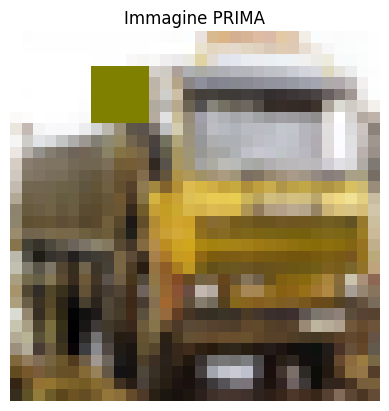

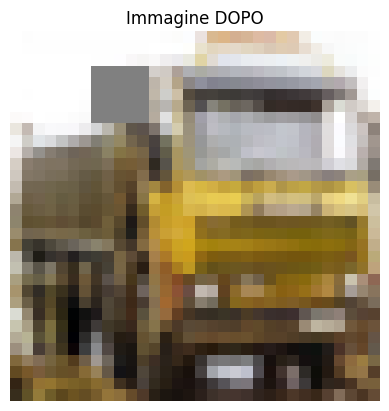

In [109]:
#LOAD DATASET
x_train, y_train, x_val, y_val, x_test, y_test = loadDataset()

#SHUFFLE
x_train, y_train = shuffle(x_train, y_train)

#REDUCE
#x_train, y_train = reduce(x_train, y_train, mtrain)
#x_val, y_val = reduce(x_val, y_val, mval)
#x_test, y_test = reduce(x_test, y_test, mtest)

show(x_train[2], "Immagine PRIMA")

#IMAGE PREPROCESSING
x_train = preprocess_images(x_train, process, px, rgb_color)
x_val = preprocess_images(x_val, process, px, rgb_color)
x_test = preprocess_images(x_test, process, px, rgb_color)

show(x_train[2], "Immagine DOPO")

#NORMALIZE
x_train = normalize(x_train)
x_val = normalize(x_val)
x_test = normalize(x_test)

#RESHAPE
x_train = reshape(x_train)
x_val = reshape(x_val)
x_test = reshape(x_test)

#SCALING
x_train, x_val, x_test = scale(x_train, x_val, x_test)

#PCA
x_train, x_val, x_test = pca(x_train, x_val, x_test, n_components)

In [110]:
param_grid = {
    'hidden_layer_sizes': [(100), (100,50)],
    'max_iter': [300],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate_init': [0.001, 0.01],
    'alpha': [1e-5, 1e-4, 1e-3, 1e-2]
}

In [111]:
model = MLPClassifier(
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    random_state=42
)
grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy',n_jobs=-1,verbose = 1)
grid.fit(x_train, y_train.ravel())
MLP = grid.best_estimator_

print(grid.best_params_)
print(grid.best_score_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01, 'max_iter': 300, 'solver': 'sgd'}
0.4766


In [112]:
pred = MLP.predict(x_test)
accuracy = accuracy_score(y_test, pred)

print(f"Abbiamo ottenuto un Accuracy del {accuracy:.4f}")

Abbiamo ottenuto un Accuracy del 0.4866
